<div class="output_png output_subarea output_execute_result">
<center>
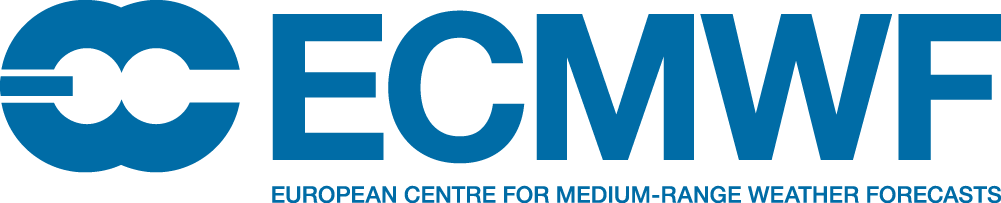</center>
</div>

# 	Bulk wind shear (Compute from levels)

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://apps.ecmwf.int/webapps/opencharts/products/medium-bulk-shear  
You can read more about bulk wind shear in [this document](https://www.ecmwf.int/en/elibrary/19905-vertical-wind-shear-and-convective-storms).


Access to ECMWF Open data is governed by the following [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).    

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 4 parameters :

* [U component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=131)
* [V component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=132)
* [10 metre U wind component](https://apps.ecmwf.int/codes/grib/param-db/?id=165)
* [10 metre V wind component](https://apps.ecmwf.int/codes/grib/param-db/?id=166)

In this example, we will use: 
- **ecmwf.opendata** Client to download the data
- **ecmwf.data** library to read and process the data (calculate the speed and shear)
- **ecmwf.geomaps** to plot the result

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> Skip this cell if you already have these libraries installed
</div>

In [ ]:
import sys
!{sys.executable} -m pip install ecmwf-data ecmwf-opendata git+https://github.com/ecmwf/ecmwf-geomaps.git

In [1]:
import ecmwf.data as ecdata
from ecmwf.geomaps import GeoMap
from ecmwf.opendata import Client

In [2]:
client = Client("https://ai4edataeuwest.blob.core.windows.net/ecmwf", beta=True)

## Retrieve requests
This product uses parameters with different vertical levels.  
10u and 10v belong to surface parameters, while u and v are pressure level parameters.  
The two types of levels can not be in the same request, so we need to make two requests for them. 

In [3]:
sfc_parameters = ['10u', '10v']
sfc_filename = 'medium-bulk-shear_sfc.grib'
sfc_filename

'medium-bulk-shear_sfc.grib'

In [4]:
pl_parameters = ['u', 'v']
pl_filename = 'medium-bulk-shear_pl.grib'
pl_filename

'medium-bulk-shear_pl.grib'

In [5]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="sfc",
    param=sfc_parameters,
    target=sfc_filename
)

In [6]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[1000,925,850,700,500,300,250,200,50],
    param=pl_parameters,
    target=pl_filename
)

## Reading and processing the data
Now we can use **ecmwf.data** to read the files.

In [7]:
sfc_data = ecdata.read(sfc_filename)
pl_data = ecdata.read(pl_filename)

The **describe()** function will give us the overview of the datasets.  

In [8]:
sfc_data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10u,heightAboveGround,10,20220104,0,12,None,165,od,oper,fc,0001
10v,heightAboveGround,10,20220104,0,12,None,166,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [9]:
pl_data.describe('u')

shortName,u
name,U component of wind
paramId,131
units,m s**-1
typeOfLevel,isobaricInhPa
level,"50,200,250,300,500,700,850,925,1000"
date,20220104
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [10]:
pl_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,v,isobaricInhPa,300,20220104,0,12,fc,None,regular_ll
1,ecmf,u,isobaricInhPa,300,20220104,0,12,fc,None,regular_ll
2,ecmf,u,isobaricInhPa,200,20220104,0,12,fc,None,regular_ll
3,ecmf,v,isobaricInhPa,500,20220104,0,12,fc,None,regular_ll
4,ecmf,u,isobaricInhPa,925,20220104,0,12,fc,None,regular_ll
5,ecmf,u,isobaricInhPa,250,20220104,0,12,fc,None,regular_ll
6,ecmf,u,isobaricInhPa,50,20220104,0,12,fc,None,regular_ll
7,ecmf,u,isobaricInhPa,1000,20220104,0,12,fc,None,regular_ll
8,ecmf,u,isobaricInhPa,850,20220104,0,12,fc,None,regular_ll


### Calculate bulk wind shear intesity between 10 m and 500 hPa
We can calculate bulk wind shear between any two levels in our dataest.  
In this case we will take the 10 m for lower level and 500 hPa for the higher level.  

First we filter out u and v component for each level, using the **select()** method.

In [11]:
u1 = sfc_data.select(shortName=['10u'])
u1.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10u,heightAboveGround,10,20220104,0,12,None,165,od,oper,fc,0001


In [12]:
v1 = sfc_data.select(shortName=['10v'])
v1.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10v,heightAboveGround,10,20220104,0,12,None,166,od,oper,fc,0001


In [13]:
u2 = pl_data.select(shortName='u',level=500)
u2.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
u,isobaricInhPa,500,20220104,0,12,None,131,od,oper,fc,0001


In [14]:
v2 = pl_data.select(shortName='v',level=500)
v2.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
v,isobaricInhPa,500,20220104,0,12,None,132,od,oper,fc,0001


And finally we calculate the wind shear intensity:

In [15]:
shear_intensity = ecdata.sqrt((u1-u2)*(u1-u2)+(v1-v2)*(v1-v2))
shear_intensity.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,10u,heightAboveGround,10,20220104,0,12,fc,None,regular_ll


Now, we can plot the data on the map. 

Magics-warning: description is not a known keyword


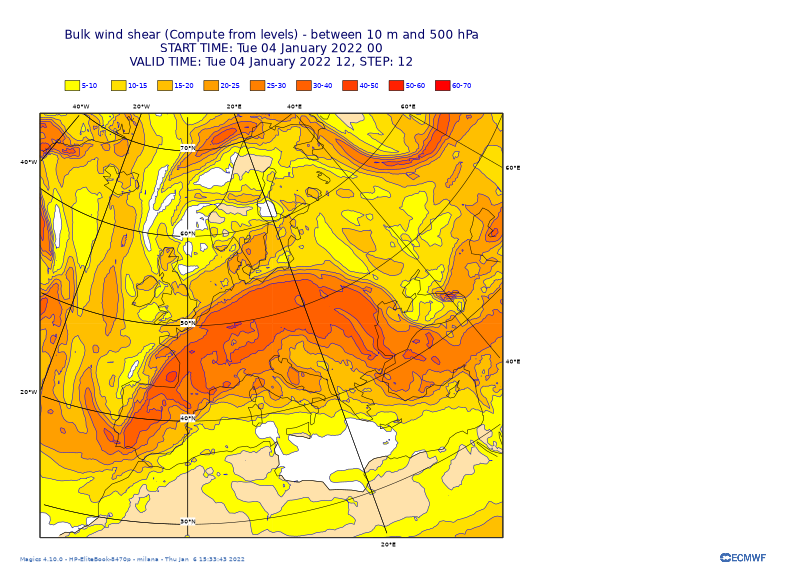

In [16]:
fig = GeoMap(area_name='europe', preset='background-foreground')

fig.contour_lines(shear_intensity, preset="sh_red_f5t70lst")

fig.title(["Bulk wind shear (Compute from levels) - between 10 m and 500 hPa", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' />",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' />, STEP: <grib_info key='step' />"])
fig.show()